In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import StratifiedKFold, KFold
import optuna
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, r2_score
from scipy.stats import mode
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data.csv")
df.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,NaN


### Exploratory Data Analysis

<Figure size 1200x600 with 0 Axes>

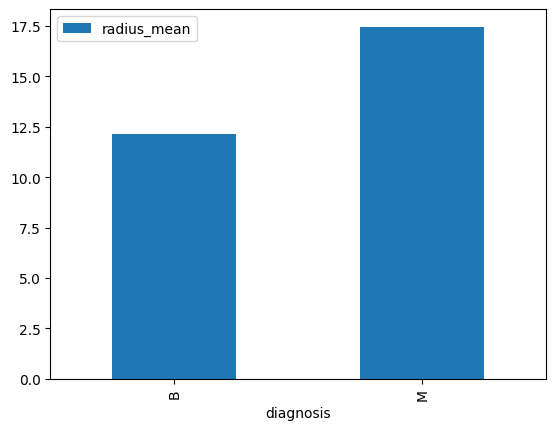

In [12]:
ardiag = df.groupby("diagnosis")["radius_mean"].mean().reset_index()
plt.figure(figsize=(12,6))
ardiag.plot(kind="bar", x="diagnosis", y="radius_mean")
plt.show()

#### This indicates that there is a direct relation of tumor size to the risk of breast cancer

<Figure size 1200x600 with 0 Axes>

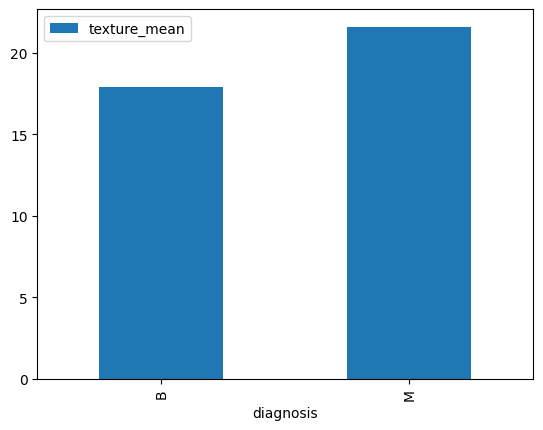

In [13]:
ardiag = df.groupby("diagnosis")["texture_mean"].mean().reset_index()
plt.figure(figsize=(12,6))
ardiag.plot(kind="bar", x="diagnosis", y="texture_mean")
plt.show()

#### This indicates that there is a direct relation of tumor texture to the risk of breast cancer

In [14]:
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### Only Diagnosis column is non numerical

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [24]:
category_count_train = df['diagnosis'].value_counts().reset_index()
category_count_train.columns = ["Target", "Count"]
category_count_train.iloc[0,1]

357

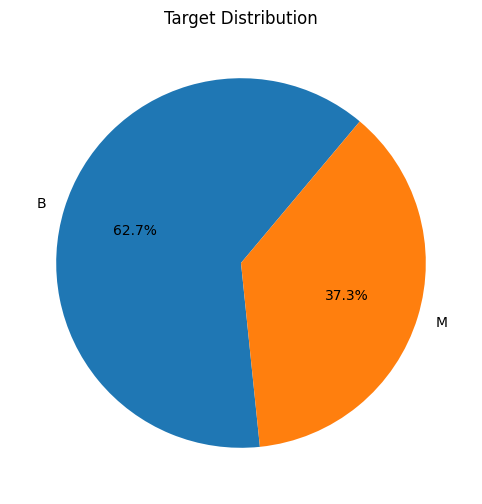

In [33]:
labels = category_count_train['Target']
counts = category_count_train['Count']
plt.figure(figsize=(8,6))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=50)
plt.title("Target Distribution")
plt.show()

#### About 63% of the data is benign and the remaining is malignant

### Let us visualize the frequency of numerical data in the dataset

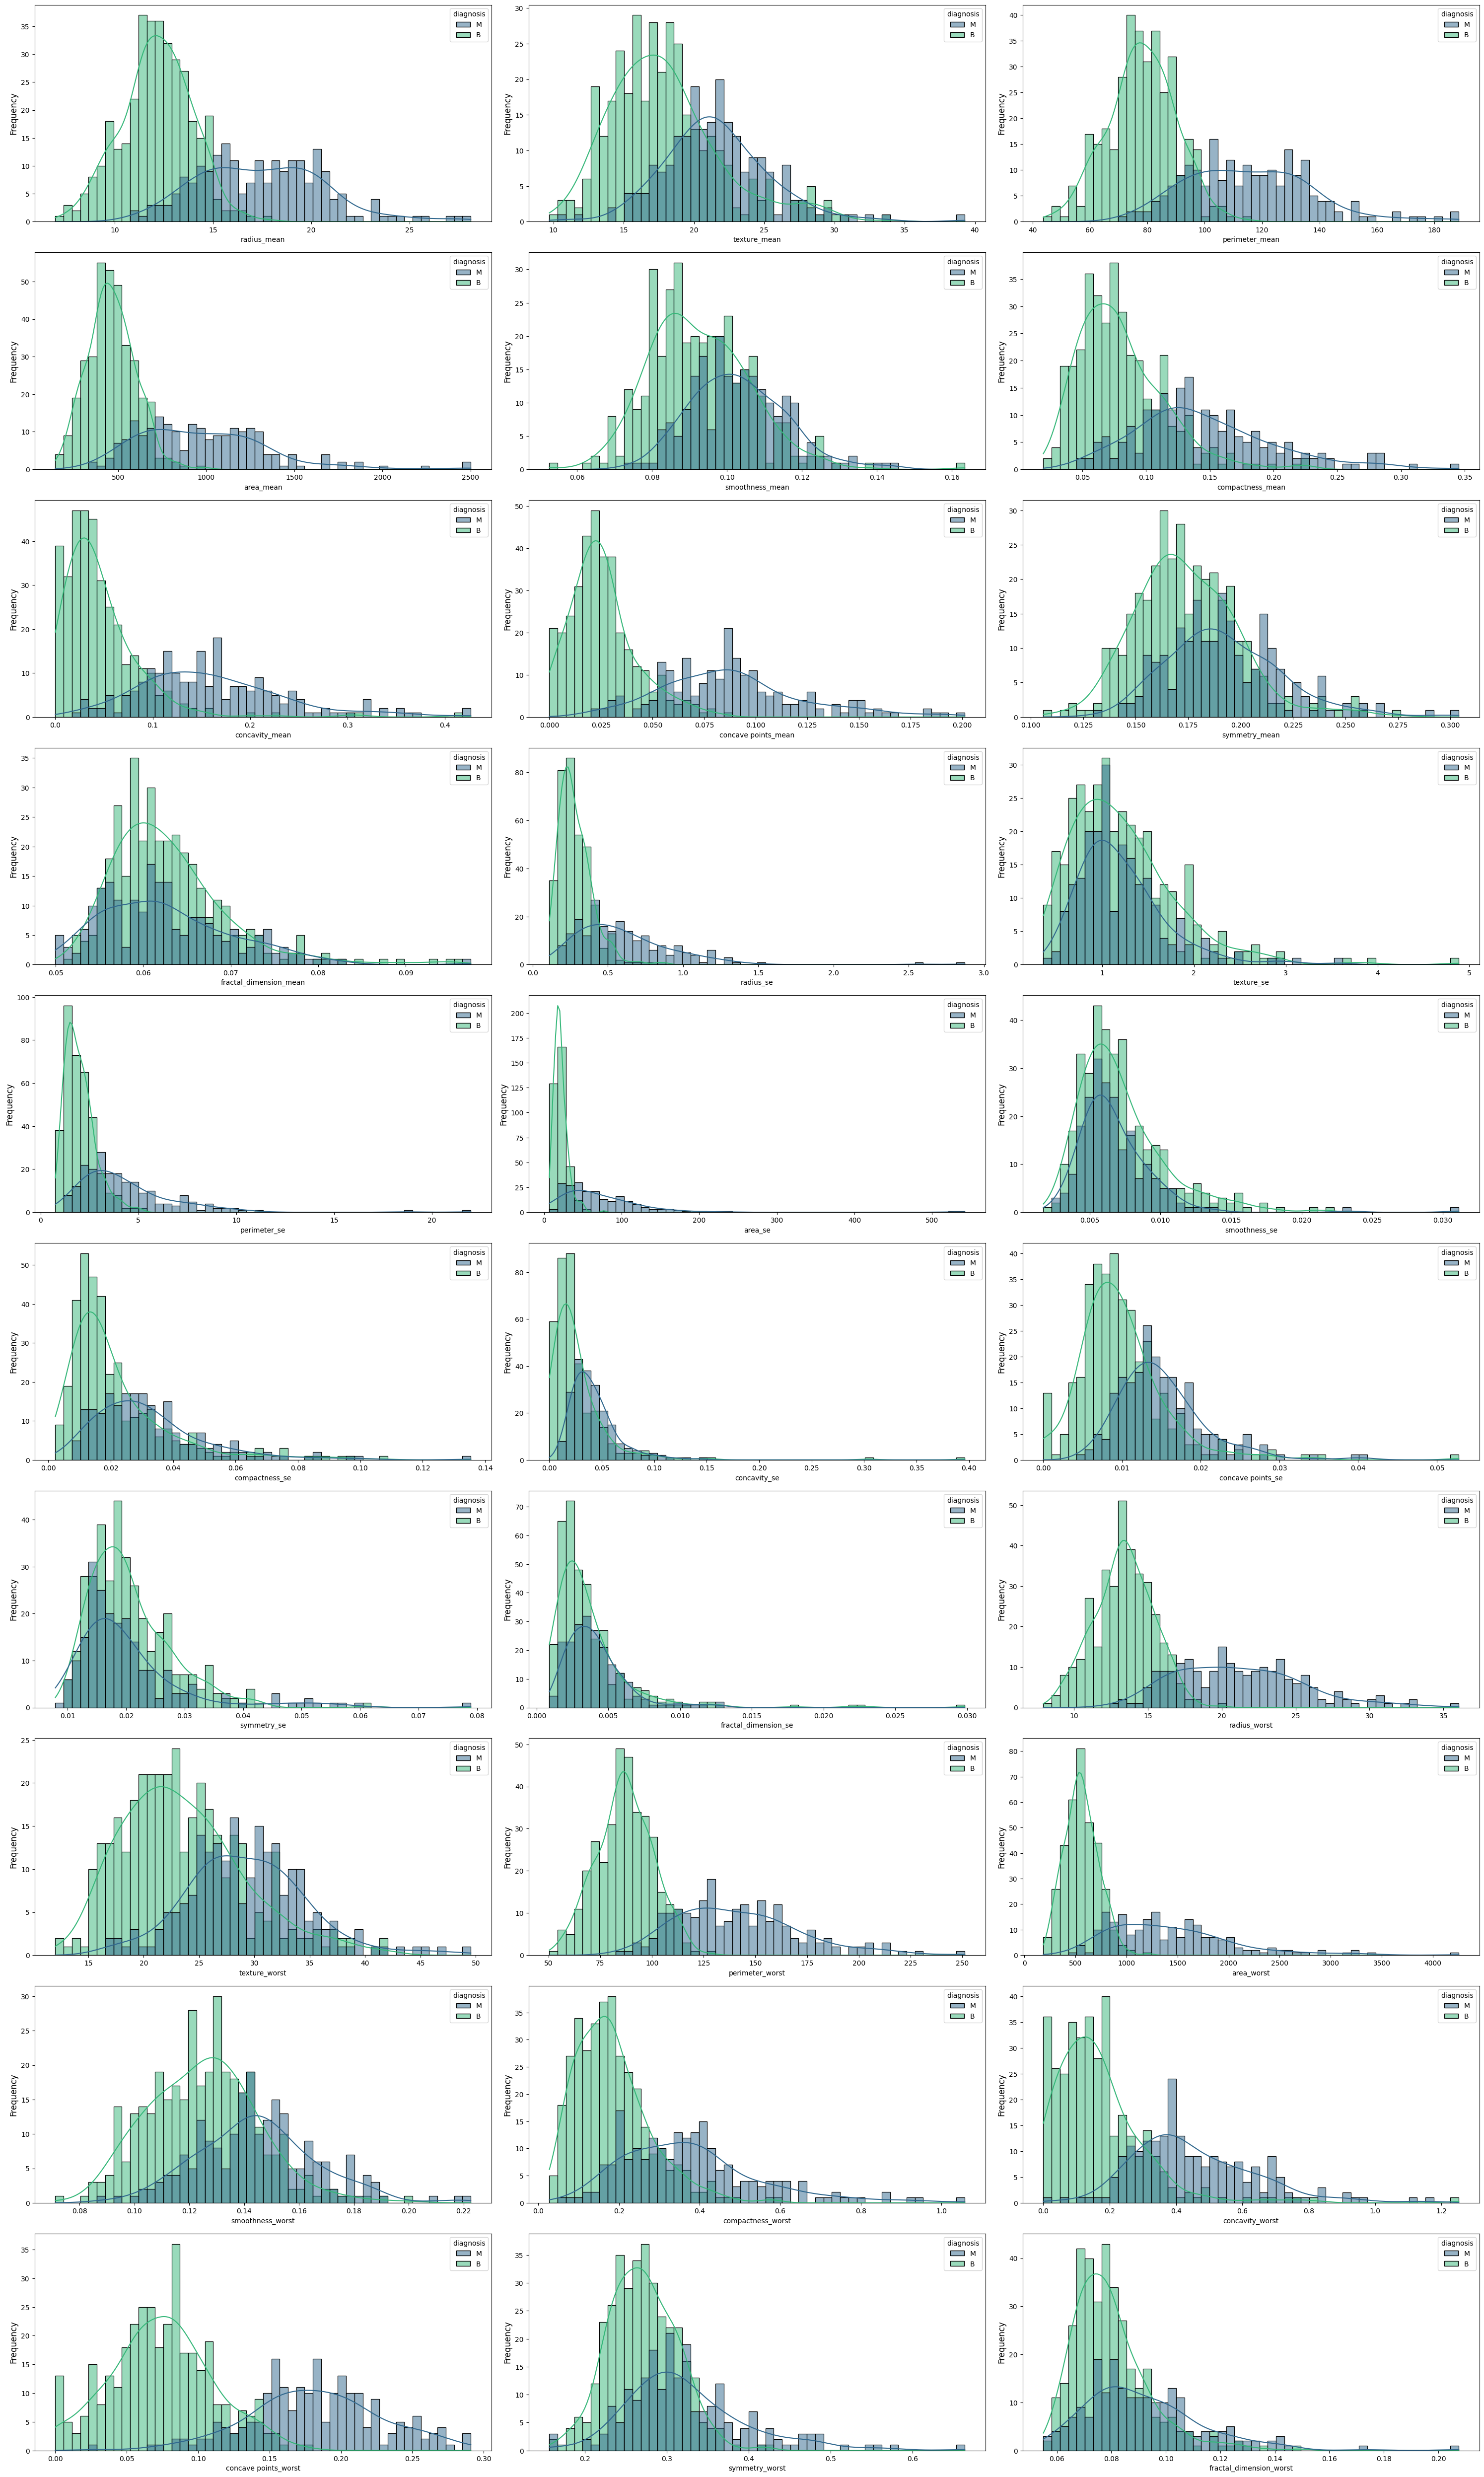

In [41]:
fig, axis = plt.subplots(10, 3, figsize=(30, 50))
plt.subplots_adjust(hspace = 0.5)

for col, ax in zip(df.select_dtypes(np.number).columns, axis.ravel()):
    sns.histplot(data = df, x = df[col], ax = ax, bins = 50, palette = 'viridis', kde = True, hue = 'diagnosis')
    ax.set_ylabel('Frequency', fontsize = 12)
    ax.set_xlabel(col, fontsize = 10)
plt.tight_layout()
plt.show()

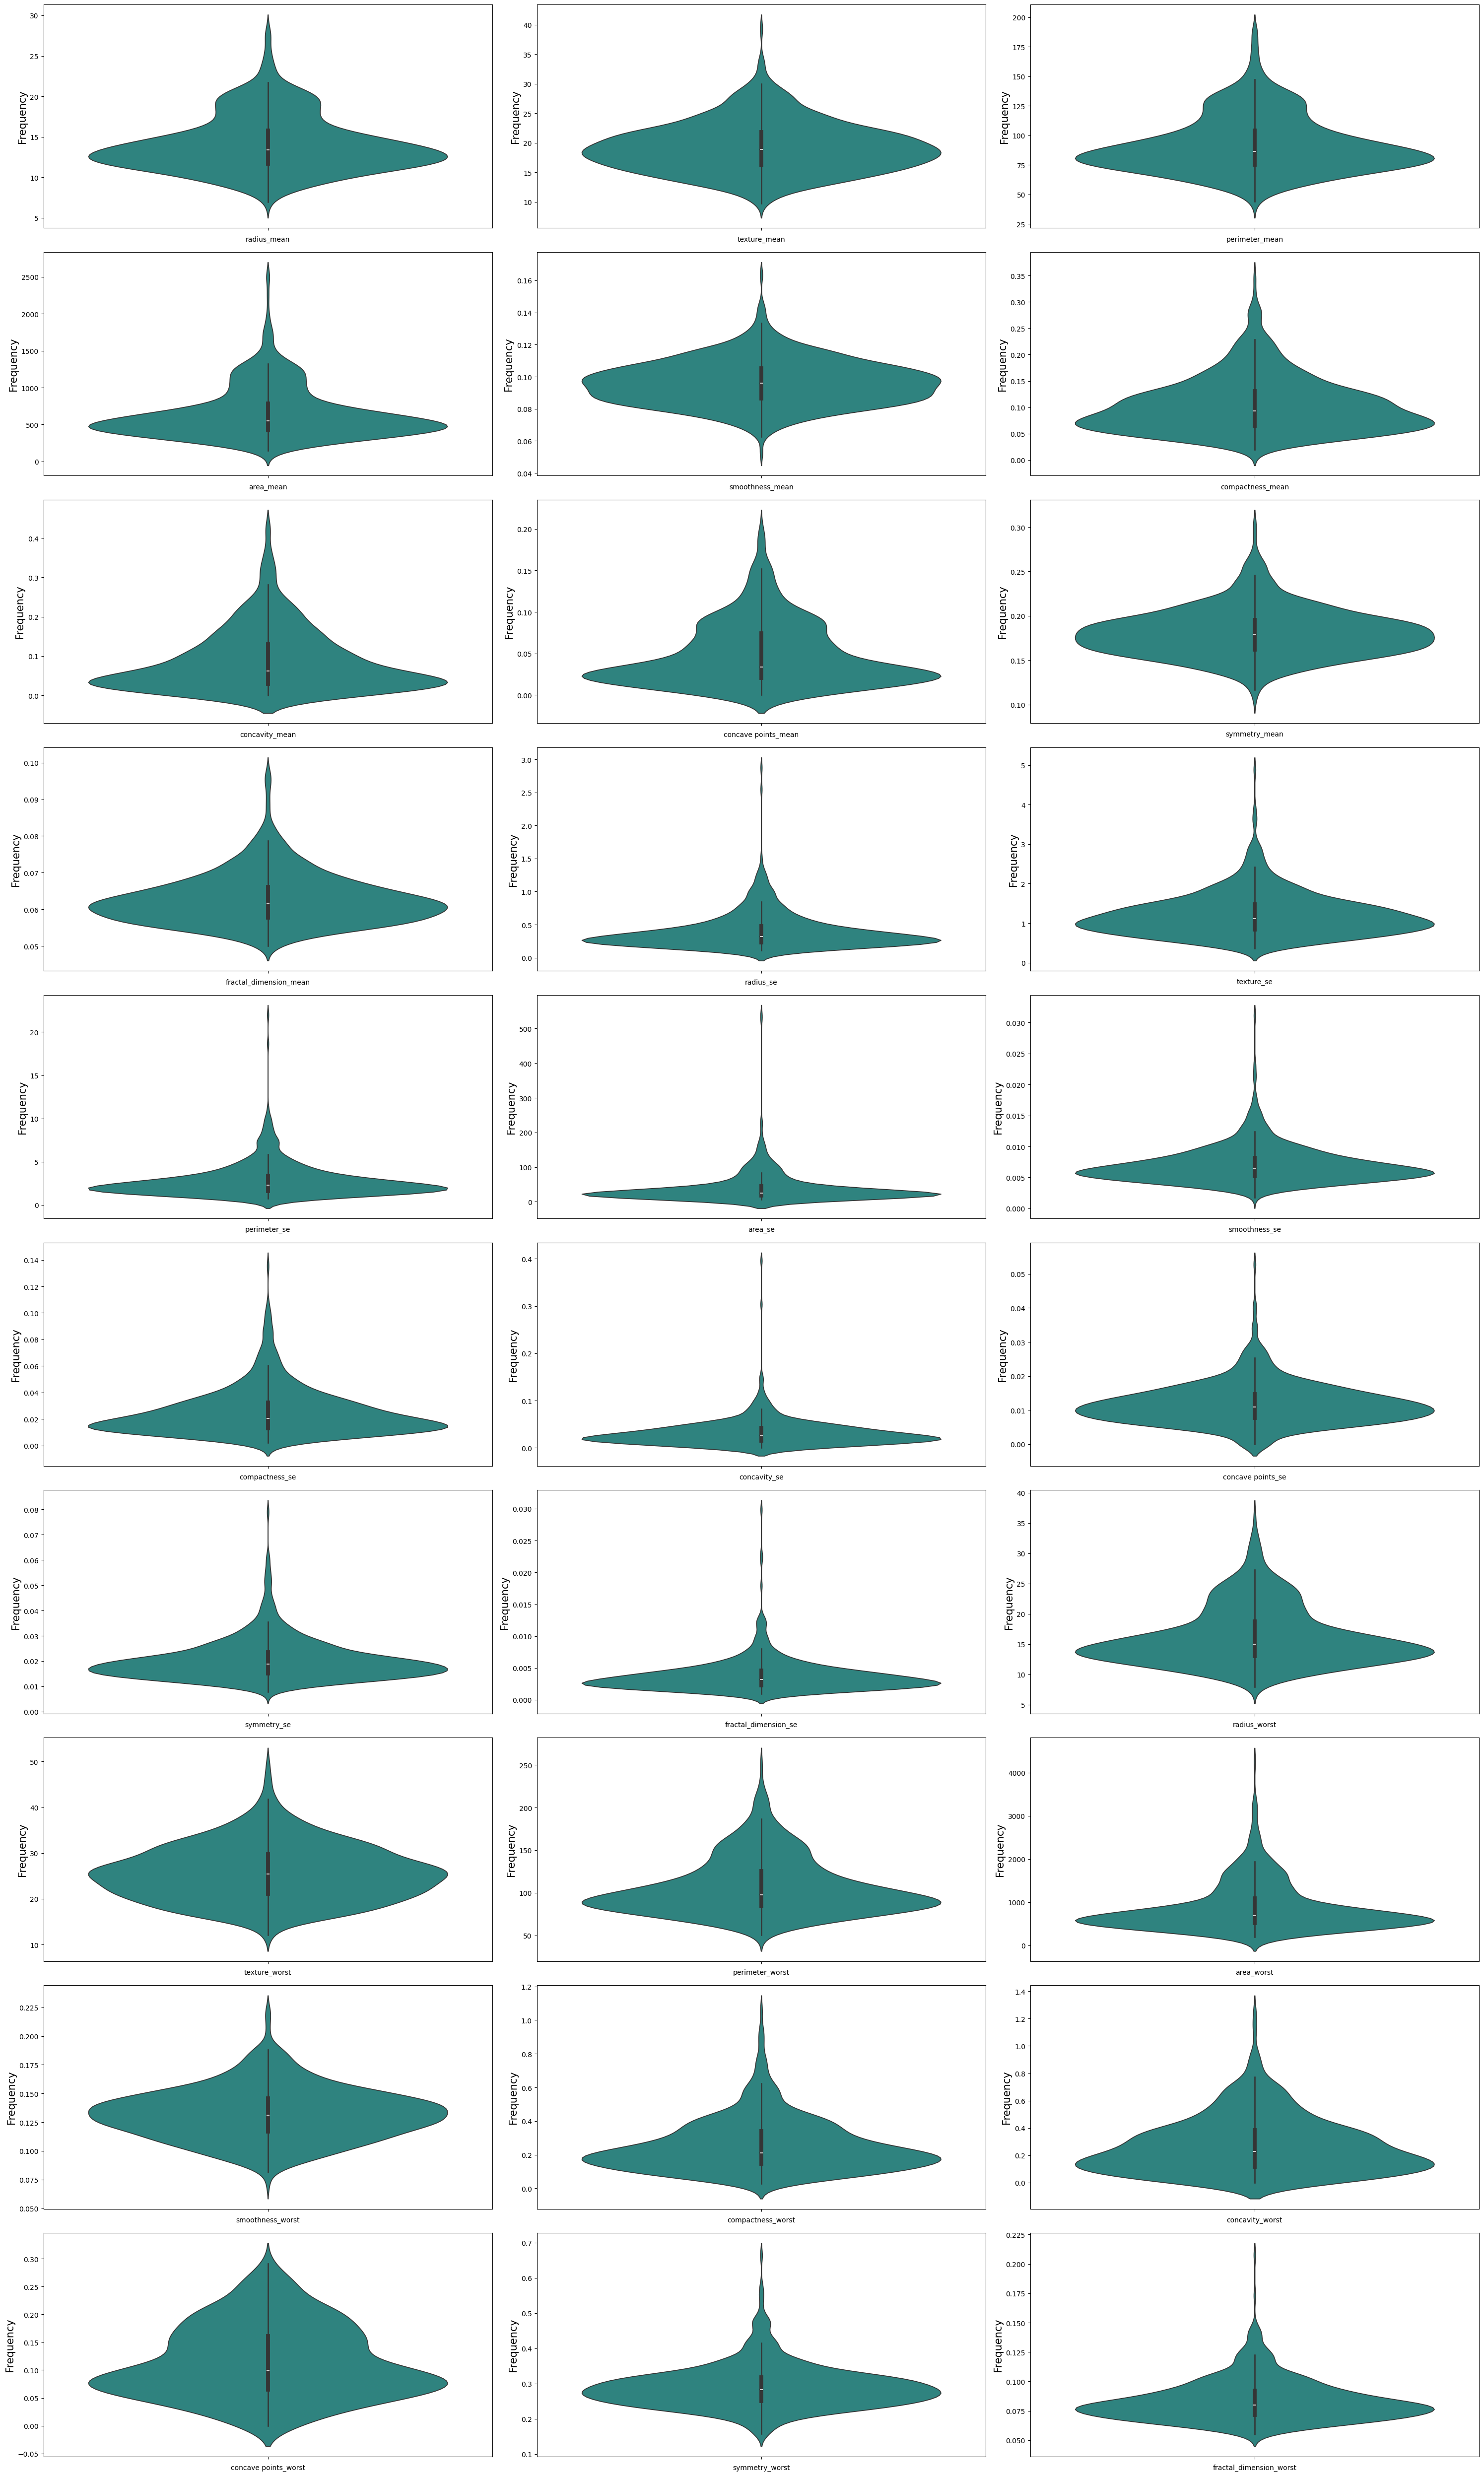

In [46]:
fig, axis = plt.subplots(10, 3, figsize=(30, 50))
plt.subplots_adjust(hspace = 0.5)

for col, ax in zip(df.select_dtypes(np.number).columns, axis.ravel()):
    sns.violinplot(data = df, y = df[col], ax = ax, palette = 'viridis')
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel(col, fontsize = 10)
plt.tight_layout()
plt.show()

<Axes: >

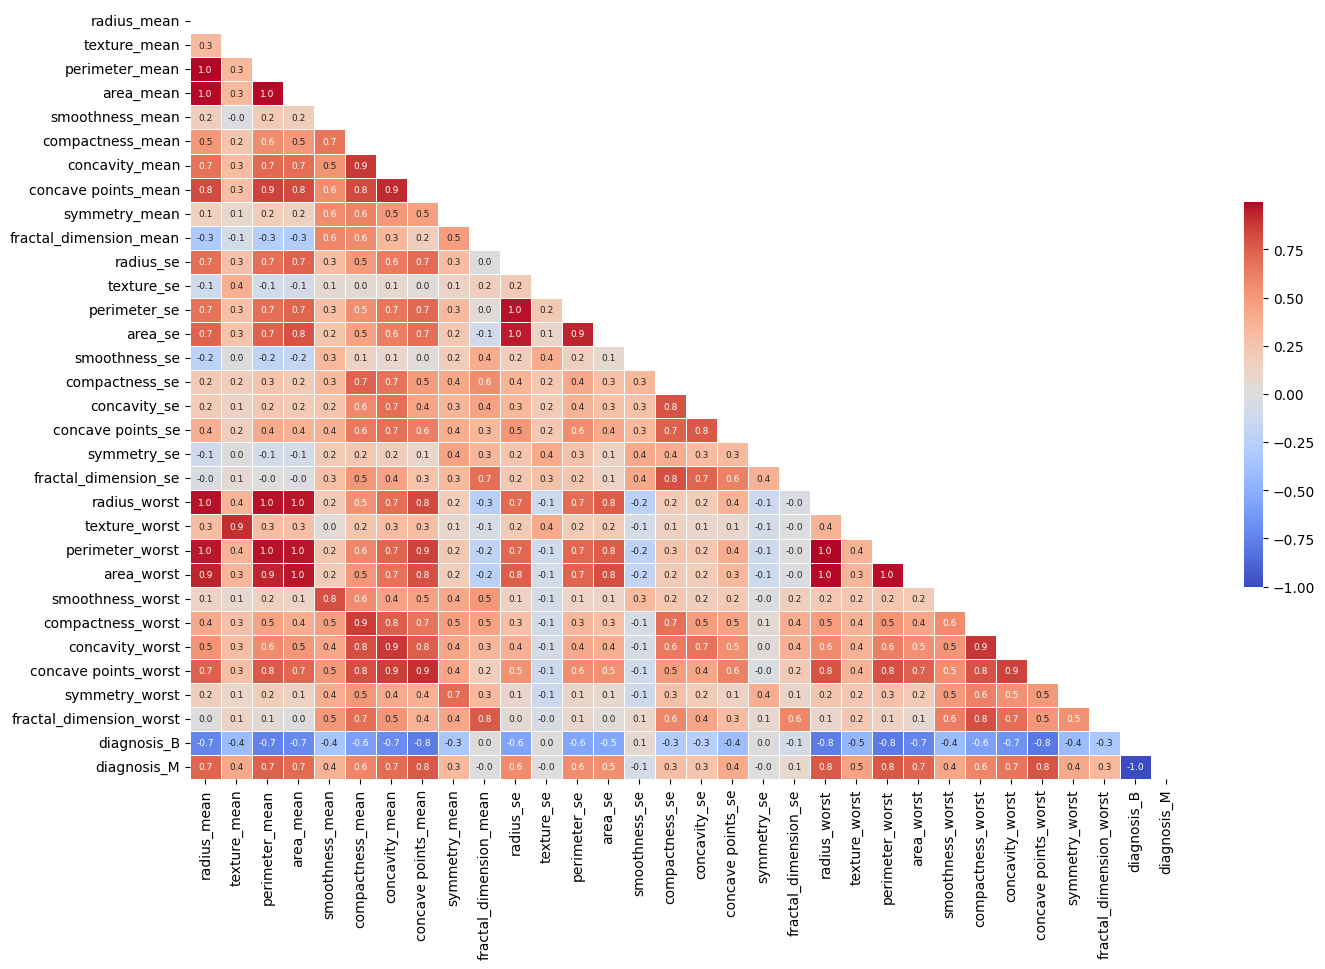

In [49]:
corr = (pd.get_dummies(df)).corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize=(16,10))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, fmt = '.1f', annot_kws = {'fontsize': 6.5}, mask = mask, cbar_kws = {"shrink": 0.5}, linewidths = .5)

In [55]:
def LabelEncoding(df):
    le = LabelEncoder()
    df['diagnosis'] = le.fit_transform(df['diagnosis'])
    return df
df = LabelEncoding(df)

In [57]:
X = df.drop(columns=["diagnosis"])
Y = df["diagnosis"]

In [59]:
def scaling(X):
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
    return X
X = scaling(X)

### Modeling for Classification and Hyperparameter Tuning